In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
from pytz import timezone

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, Normalizer, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.utils.np_utils import to_categorical
from keras import optimizers
import keras
import talib

def get_CU():
    import dovahkiin as dk
    dp = dk.DataParser()
    X = dp.get_data("cu")
    return X

def get_SP500():
    import pandas_datareader as pdr    
    SP500 = pdr.get_data_yahoo('^GSPC')
    return SP500

def get_X_data():
    import dovahkiin as dk
    dp = dk.DataParser()
    X = dp.get_data("cu")
    return X

X = get_X_data()

Using TensorFlow backend.


In [2]:
fig_size = (12, 9)
plt.rcParams["figure.figsize"] = fig_size

In [3]:
X["HLC"] = (X.high + X.low + X.close) / 3

In [4]:
X["return"] = X.HLC.pct_change()

In [5]:
X["return"] = X["return"].fillna(0)

### Wavelet Decomposition

In [6]:
import pywt
from statsmodels.robust import stand_mad

# Wavelet Decomposition
level = 9
haar = pywt.Wavelet("haar")
coeffs = pywt.wavedec(X["return"].values, haar, level=9)
recomposed_return = pywt.waverec(coeffs, haar)

In [7]:
recomposed_return

array([ -6.94567017e-20,  -1.52746431e-05,  -3.30791130e-04, ...,
        -4.46399095e-04,   3.44784337e-04,   3.44784337e-04])

In [8]:
X["return"] - recomposed_return[:-1]

date_time
2003-08-01 09:00:00+08:00    6.945670e-20
2003-08-01 09:01:00+08:00    7.453890e-20
2003-08-01 09:02:00+08:00    1.626303e-19
2003-08-01 09:03:00+08:00    1.626303e-19
2003-08-01 09:04:00+08:00    2.710505e-20
2003-08-01 09:05:00+08:00   -2.710505e-20
2003-08-01 09:06:00+08:00    0.000000e+00
2003-08-01 09:07:00+08:00   -2.710505e-20
2003-08-01 09:08:00+08:00   -5.421011e-20
2003-08-01 09:09:00+08:00   -1.355253e-20
2003-08-01 09:10:00+08:00   -2.168404e-19
2003-08-01 09:11:00+08:00   -8.131516e-20
2003-08-01 09:12:00+08:00   -2.710505e-20
2003-08-01 09:13:00+08:00   -4.065758e-20
2003-08-01 09:14:00+08:00   -3.388132e-20
2003-08-01 09:15:00+08:00   -2.710505e-20
2003-08-01 09:16:00+08:00   -5.421011e-20
2003-08-01 09:17:00+08:00   -5.421011e-20
2003-08-01 09:18:00+08:00   -1.694066e-20
2003-08-01 09:19:00+08:00   -2.710505e-20
2003-08-01 09:20:00+08:00    2.710505e-20
2003-08-01 09:21:00+08:00    2.710505e-20
2003-08-01 09:22:00+08:00   -2.710505e-20
2003-08-01 09:23:00+08:0

In [9]:
recomposed_return[:-1]

array([ -6.94567017e-20,  -1.52746431e-05,  -3.30791130e-04, ...,
        -3.99795386e-04,  -4.46399095e-04,   3.44784337e-04])

In [10]:
diff = recomposed_return[:-1] - X["return"].values

In [11]:
np.abs(diff).sum()

1.2389725842013506e-13

### Wavelet De-noising

In [12]:
sigma = stand_mad(coeffs[-1])
uthresh = sigma*np.sqrt(2*np.log(len(X["return"].values)))
denoised = coeffs[:]

In [13]:
denoised[1:] = (pywt.threshold(i, value=uthresh) for i in denoised[1:])

In [14]:
denoised_return = pywt.waverec(denoised, haar)

In [15]:
X["denoised"] = denoised_return[:-1]

In [16]:
diff = denoised_return[:-1] - X["return"].values
correlation = np.corrcoef(denoised_return[:-1], X["return"].values)
print("There are total of {} elements".format(len(denoised_return)))
print("Total absolute difference: {}".format(np.abs(diff).sum()))
print("Correlation between denoised and original: {}".format(correlation[0][1]))

There are total of 958636 elements
Total absolute difference: 230.6085907747903
Correlation between denoised and original: 0.9060392654130378


In [17]:
pd.DataFrame({"denoised": denoised_return[1:]}, index=X.index).plot()
X["return"].plot()

### Divide Data into Train and Test

In [18]:
X_train = X["2012":"2015"]
X_test = X["2016":]
print("Test: {:.2f}%".format(100 * len(X_test)/len(X["2012":])))
print("Train: {:.2f}%".format(100 * len(X_train)/len(X["2012":])))

Test: 33.35%
Train: 66.65%


In [19]:
y = X["return"].shift(-1)
y = y.fillna(0)

In [20]:
y_train = y["2012":"2015"]
y_test  = y["2016":]

In [21]:
del X_train['HLC']
del X_train['open']
del X_train['high'] 
del X_train['low']
del X_train['close']
del X_train['volume']
del X_train['openint']

del X_test["HLC"]
del X_test['open']
del X_test['high'] 
del X_test['low']
del X_test['close']
del X_test['volume']
del X_test['openint']

### Normalization

In [22]:
# Normalize de-noised return
scaler = MinMaxScaler()

In [23]:
X_train["denoised_scaled"] = scaler.fit_transform(pd.DataFrame(X_train["denoised"].values))

In [24]:
X_test["denoised_scaled"] = scaler.transform(pd.DataFrame(X_test["denoised"].values))

In [25]:
time_series_step=4

def timeseries_to_supervised(raw_time_series, lag):
    p = {}
    for i in range(1, lag+1):
        p["{}".format(i)] = raw_time_series.shift(i).fillna(0)
    p["0"] = raw_time_series
    
    supervised_data = pd.Panel(p)
    return supervised_data

def non_shuffling_train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

def create_supervised_X(raw_time_series, lag):
    supervised_X = timeseries_to_supervised(raw_time_series, lag)
    swaped_supervised_X = supervised_X.swapaxes(0, 1)
    return swaped_supervised_X

In [26]:
X_train = create_supervised_X(pd.DataFrame(X_train["denoised_scaled"]), time_series_step)
X_test  = create_supervised_X(pd.DataFrame(X_test["denoised_scaled"]), time_series_step)

In [27]:
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

### LSTM

In [31]:
batch_size = 15
features = 1

In [32]:
X_train.shape

(333465, 5, 1)

In [33]:
X_test.shape

(166845, 5, 1)

In [38]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []


    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
    def on_batch_begin(self, batch, logs={}):
        self.model.reset_states()

In [40]:
model = Sequential()
model.add(
    LSTM(128, batch_input_shape=(batch_size, time_series_step+1, features), stateful=False, 
         return_sequences=True, 
         activation="relu"
        ))

model.add(
    LSTM(128, stateful=False, 
         return_sequences=True, 
         activation="relu"
        ))
    
model.add(LSTM(32, activation="relu", stateful=True))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1))
# model.add(Activation('softmax'))

In [41]:
model.compile(loss="mse", optimizer="adadelta")

In [42]:
history = LossHistory()
history4 = model.fit(X_train.values, 
                     y_train, 
                     epochs=5, 
                     batch_size=batch_size, 
                     shuffle=False, 
                     validation_data=(X_test.values, y_test),
                     callbacks=[history]
                    )

Train on 333465 samples, validate on 166845 samples
Epoch 1/5
333465/333465 [==============================] - 720s - loss: 3.5642e-04 - val_loss: 0.0043
Epoch 2/5
333465/333465 [==============================] - 712s - loss: 3.9261e-05 - val_loss: 0.0018
Epoch 3/5
333465/333465 [==============================] - 690s - loss: 3.6623e-05 - val_loss: 0.0010
Epoch 4/5
333465/333465 [==============================] - 709s - loss: 3.5497e-05 - val_loss: 6.3225e-04
Epoch 5/5
333465/333465 [==============================] - 701s - loss: 3.4838e-05 - val_loss: 4.3346e-04


In [53]:
total_history_val_loss = history.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss'] + history3.history['val_loss']
total_history_loss = history.history['loss'] + history2.history['loss'] + history3.history['loss'] + history3.history['loss']

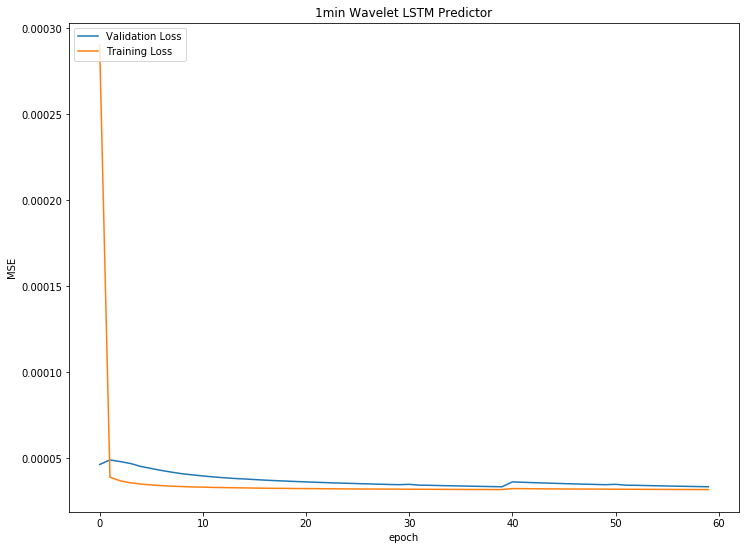

In [59]:
# summarize history for loss

# plt.plot(SAE_results[0].history['loss'][:size_limit])
# plt.plot(history.history['loss'][:size_limit])
# plt.plot(deep_results[0].history['loss'][:size_limit])
plt.plot(total_history_val_loss)
plt.plot(total_history_loss)
plt.title('1min Wavelet LSTM Predictor')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Validation Loss', "Training Loss", ], loc='upper left')
plt.show()

In [43]:
model.save("Wavelet_LSTM_1min_stateless")

In [44]:
y_test_predict_scaled = model.predict(X_test.values, batch_size=15)

In [45]:
y_test_predict_scaled.size

166845

In [46]:
y_test_predict = y_scaler.inverse_transform(y_test_predict_scaled)
y_test_predict = y_test_predict.reshape(y_test_predict.shape[0])

In [47]:
y_test_actual = y_scaler.inverse_transform(y_test)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [50]:
y_test_predict.size

166845

In [51]:
y_test_actual.size

166845

In [52]:
np.corrcoef(y_test_predict, y_test_actual)

array([[ 1.        ,  0.04470938],
       [ 0.04470938,  1.        ]])

In [140]:
y_test = y["2016":]

In [53]:
y_test = pd.DataFrame(y_test)

In [54]:
y_test["predict"] = y_test_predict

In [55]:
y_test["predict_scaled"] = y_test_predict_scaled

In [56]:
y_test

,0,predict,predict_scaled
0,0.571092,0.000436,0.560160
1,0.548666,0.000933,0.566012
2,0.548693,0.001324,0.570617
3,0.563428,0.001588,0.573730
4,0.555037,0.001707,0.575134
5,0.552425,0.001707,0.575130
6,0.550357,0.001704,0.575102
7,0.536375,0.001704,0.575101
8,0.532962,0.001700,0.575048
9,0.535060,0.001696,0.575000
